### setup
Please make sure you folder looks like this:
- this notebook
- exercise_utils.py
- data_*.csv

You can also download these files from:
https://gitlab.com/rmenke/ds_at_bc

# Exercise
The exercise will attempt to convey important skills and concepts in applying data science in a production environment.
- Thinking about the data
 - what is it like and what could I do with it?
 - what is the business objective?
- Generating value from ML:
 - establishing a baseline
 - improving as required
 
 ## The challange that you have been set:
You are part of a fast growing social media startup HypeVentures that provides chat and discussion space technology to other startup to improve the customer engagement with the content the users post. Management has hired you to sort out their marketing messaging as the last marketing guy quit and they intend to hire a bunch of different topic experts to deal with the different forums.
 

1. What do people talk about?
2. Can we cluster the conversation topics?
3. Can we label some of them by hand?
4. Use that to label the rest?
5. Classify some new incomming data?

### Let's start with clustering some sample data
- investigate how well clustering works on this data
- Cluster data that has been labeled, so we can evaluate the quality of the results
- Once successfull we'll go and tell our boss to stof paying amazon for labeling services and jsut do everthing with clustering

In [ ]:
# Imports we'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklean features
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer

Data ingress
load 'data_comp.graphics_sci.med_categories_train.csv' into a pandas dataframe and inspect it

In [ ]:
# df2 = pd.read_csv('data_alt.atheism_soc.religion.christian_categories_train.csv')
df2 = pd.read_csv('data_comp.graphics_sci.med_categories_train.csv')

# use .head() to see the top
df2 = df2.dropna()
df2.head()

In [ ]:
# Make a histogram of the data to see the distribution
df2[['data', 'subject']].subject.plot(kind='hist')
plt.show()

Vectorize the text data 

1. Either using a counting vectorizer 
2. or a hashing one

Using english default stop words:
stop words are words like: and, to, I etc. Complete list for a common usecase: https://gist.github.com/sebleier/554280

## NLP

- statistical analysis of documents (distributional semantics)
- word2vec
- doc2vec
- named entity recognition


We'll be using simple statistical methods to get started.

*Remember setting a baseline*

### Count the word occurances

Get the words in a string and assign a value. Do until complete: [Example](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

We use the CountVectorizer from sklearn.feature_extraction.text

In [ ]:
# Example
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names(), index=corpus )

Now the same thing with stop words:

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)
pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names(), index=corpus )

In [ ]:
# now let's appy this to our data
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(df2.data)

Now we do tow pre processing steps:
- latent semantic analysis
- Normalize the data

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

In [ ]:
# Latent analysis
svd = TruncatedSVD(n_components=10,  random_state=42)
X_reduced = svd.fit_transform(X_train_counts)

In [ ]:
# What did we just do?
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))
 

In [ ]:
# Normalize
norm = Normalizer()
X_2 = norm.fit_transform(X_reduced)

# Clustering
Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). [wikipedia](https://en.wikipedia.org/wiki/Cluster_analysis)
 
## Different methods 
There are many methods, with different strengths and weaknesses and applications. 
- Centroid-based clustering
 - The most common technique is k-means clustering. 
 - specify the number of clusters
 - difficult to find the correct number if unknown
 - non deterministic
 - scales badly

- Distribution-based clustering
 - Assumes a distribution on the data (Gausian)

- Density-based clustering
 - Popular algos are DBSCAN and OPTICS
 
- Hierarchical clustering
 - Good for data that can be spit with a dendogram


### No one method to rule them all

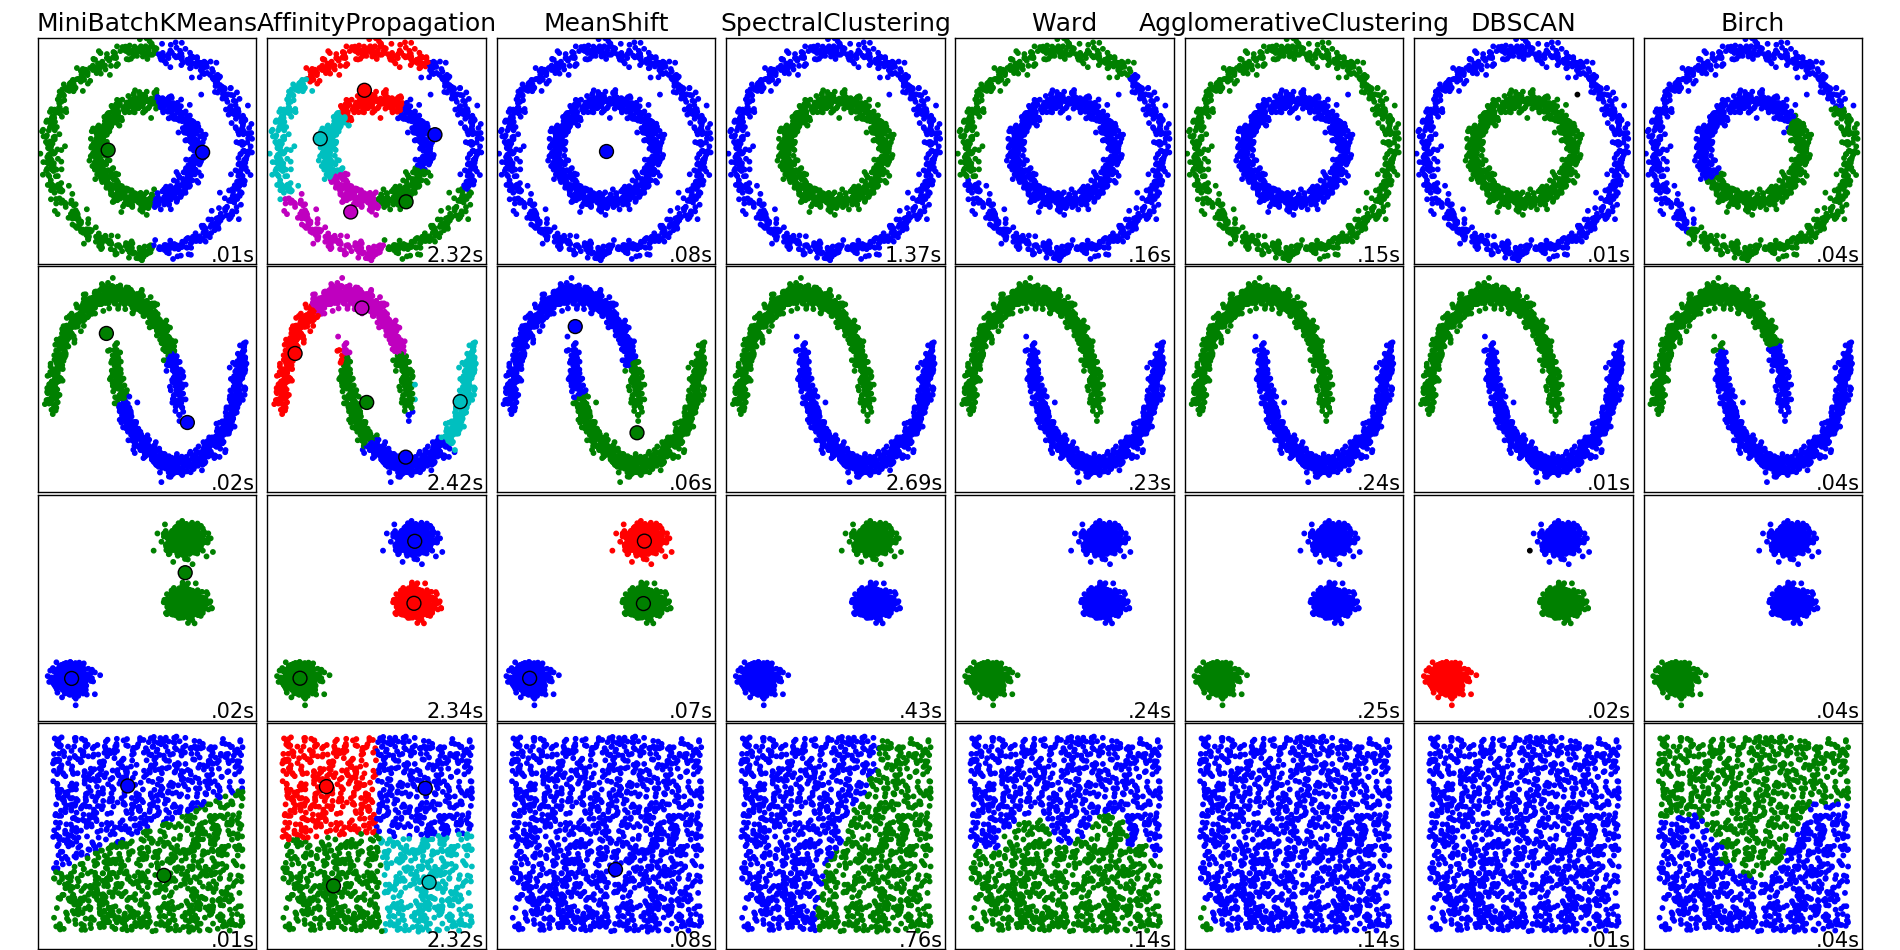

In [ ]:
from sklearn.cluster import DBSCAN, Birch, SpectralClustering, MeanShift, AffinityPropagation, KMeans, OPTICS 
from exercise_utils import match_labels, eval_clustering

In [ ]:
# Try Birch or Affinity Propagation
clustering = Birch()
#clustering = AffinityPropagation()
clustering.fit(X_2)
y_pred = match_labels(df2.subject.values,clustering.labels_ )
np.mean(df2.subject.values == y_pred)
#set(clustering.labels_)

In [ ]:
# Lets try DBSCAN or OPTICS
clustering = DBSCAN(eps=0.9)
clustering.fit(X_2)
print(set(clustering.labels_))

y_pred = match_labels(df2.subject.values,clustering.labels_ )
np.mean(df2.subject.values == y_pred)

In [ ]:
# Try Spectral Clustering
clustering = SpectralClustering(n_clusters=2, random_state=42 )
clustering.fit(X_2)
y_pred = match_labels(df2.subject.values,clustering.labels_ )
print(np.mean(df2.subject.values == y_pred))
plt.hist(clustering.labels_,alpha=0.5)
df2.subject.plot(kind='hist', alpha=0.5)
plt.legend(['true','predicted'])
plt.show()


In [ ]:
# Try KMeans
clustering = KMeans(n_clusters=2,  n_jobs=-1, init='k-means++', random_state=42, max_iter=500)
clustering.fit(X_2)
y_pred = match_labels(df2.subject.values, clustering.labels_ )
np.mean(df2.subject.values == y_pred)

In [ ]:
plt.hist(clustering.labels_)
df2.subject.plot(kind='hist', alpha=0.5)
plt.legend(['predicted','true'])
plt.show()


## Success
That looks pretty good!

Let's expand this to four categories.

In [ ]:
# Do the same thing for the file data_comp.graphics_sci.med_alt.atheism_soc.religion.christian_categories_train.csv
# load it and inspect
df4 = pd.read_csv('data_comp.graphics_sci.med_alt.atheism_soc.religion.christian_categories_train.csv')
df4 = df4.dropna()
df4.head()

In [ ]:
# Perform SVD and normalization
X_train_counts = count_vect.fit_transform(df4.data)
svd = TruncatedSVD(n_components=40, random_state=42)
X_reduced = svd.fit_transform(X_train_counts)


norm = Normalizer()
X_4 = norm.fit_transform(X_reduced)

In [ ]:
# Inspect the result of normalization
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))


In [ ]:
# KMeans again
clustering = KMeans(n_clusters=4,  n_jobs=-1, init='k-means++', random_state=42, max_iter=500)
clustering.fit(X_4)
y_pred = match_labels(df4.subject.values,clustering.labels_ )
np.mean(df4.subject.values == y_pred)
    

In [ ]:
# Plot the result histogram
plt.hist(clustering.labels_)
plt.hist(clustering.labels_)
plt.show()
df4.subject.plot(kind='hist')
plt.show()

In [ ]:
#Print the results
results = pd.DataFrame(data=[df4.subject.values, clustering.labels_], index=["labeled","guessed"]).T
results.groupby("labeled")["guessed"].mean()

In [ ]:
results.groupby("labeled")["guessed"].median()

In [ ]:
y_pred = match_labels(df4.subject.values, clustering.labels_ )
np.mean(df4.subject.values == y_pred)


In [ ]:
# And a basic q-q plot
plt.scatter(df4.subject.values , y_pred, alpha=0.005, s=200)
plt.ylabel("predicted")
plt.xlabel("True")
plt.show()


## Lessons learnt
- Humble pie
 - unlabled data is hard (unsupervised learning)
 - human labeling is extremely valuable
 - Always check your work
- Curse of dimensionality 

# Bonus material

In [ ]:
# Hashing Vectorizer
from sklearn.feature_extraction.text import HashingVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = HashingVectorizer(n_features=100, alternate_sign=False)
X = vectorizer.fit_transform(corpus)
print("Shape:", X.shape)
print("Features:",X.toarray())